In [1]:
import os
import torch

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
#1. pepare data
from datasets import load_dataset
from transformers import AutoTokenizer

In [4]:
raw_datasets = load_dataset("conll2003")

In [5]:
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

In [6]:
#2. processing the data
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def align_labels_with_tokens(labels, word_ids):
    """
    Align NER labels with tokenized subwords
    - Special tokens ([CLS], [SEP]) get label -100 (ignored in loss)
    - First subword of a word gets the original label
    - Subsequent subwords get -100 or I-label (if original was B-label)
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [8]:
def tokenize_and_align_labels(examples):
    """
    Tokenize pre-split words and align labels for batches
    - is_split_into_words=True tells tokenizer inputs are already word-split
    - truncation=True ensures sequences fit model's max length
    """
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [9]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

In [10]:
#data collation
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

2025-11-21 20:36:51.472853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#prepare dataloaders
from torch.utils.data import DataLoader

In [12]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,  # Shuffle training data
    collate_fn=data_collator,
    batch_size=8,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    collate_fn=data_collator, 
    batch_size=8,
)

In [13]:
#initialize model
from transformers import AutoModelForTokenClassification

In [14]:
# Create label mappings for model configuration
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [15]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#optimizer and scheduler
from torch.optim import AdamW
from transformers import get_scheduler

In [17]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [18]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

In [19]:
# Linear learning rate schedule: starts at lr, decreases to 0
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [20]:
#accelerate setup
from accelerate import Accelerator
accelerator = Accelerator()

In [21]:
#prepare all objects for training (moves to correct device, wraps for distributed)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [22]:
#training loop
from lab2_trainingloop import training_loop

In [23]:
hf_training = training_loop(model, train_dataloader,eval_dataloader, lr_scheduler, optimizer, label_names)

  0%|          | 0/5268 [00:00<?, ?it/s]

Loss: 2.0970561504364014
Loss: 1.9056057929992676
Loss: 1.7943326234817505
Loss: 1.6291966438293457
Loss: 1.3864632844924927
Loss: 1.8226466178894043
Loss: 1.2494038343429565
Loss: 1.254089117050171
Loss: 1.0122519731521606
Loss: 1.1731547117233276
Loss: 1.2036093473434448
Loss: 0.9901246428489685
Loss: 0.897578239440918
Loss: 0.7561163306236267
Loss: 0.9082088470458984
Loss: 0.8662617802619934
Loss: 1.4039031267166138
Loss: 0.5794388651847839
Loss: 1.1009215116500854
Loss: 0.6901348233222961
Loss: 0.6381804347038269
Loss: 0.5675950050354004
Loss: 0.9843507409095764
Loss: 1.057159185409546
Loss: 0.662001371383667
Loss: 0.7740672826766968
Loss: 0.6066303253173828
Loss: 0.43434080481529236
Loss: 0.7243571877479553
Loss: 0.8644463419914246
Loss: 0.5214199423789978
Loss: 0.6932522058486938
Loss: 0.5575103163719177
Loss: 0.9624401330947876
Loss: 0.5427671074867249
Loss: 0.5249539613723755
Loss: 0.806854784488678
Loss: 0.638388991355896
Loss: 0.35733839869499207
Loss: 0.47280025482177734
Los

In [24]:
# Wait for all processes to reach this point
accelerator.wait_for_everyone()

# Unwrap model from distributed training wrapper
unwrapped_model = accelerator.unwrap_model(model)

# Save model weights using accelerator's save function
output_dir = "bert-finetuned-ner-accelerate"
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

# Save tokenizer (only on main process to avoid duplicates)
if accelerator.is_main_process:
    tokenizer.save_pretrained(output_dir)

In [25]:
from transformers import pipeline

In [26]:
# Load fine-tuned model into pipeline for easy inference
model_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", 
    model=model_checkpoint, 
    aggregation_strategy="simple"  # Groups B- and I- tokens together
)

/usr/local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [27]:
# Test the model
result = token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")
# Output: [
#   {'entity_group': 'PER', 'score': 0.999, 'word': 'Sylvain', ...},
#   {'entity_group': 'ORG', 'score': 0.965, 'word': 'Hugging Face', ...},
#   {'entity_group': 'LOC', 'score': 0.999, 'word': 'Brooklyn', ...}
# ]

In [28]:
print(result)

[{'entity_group': 'PER', 'score': np.float32(0.9988506), 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': np.float32(0.9647625), 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': np.float32(0.9986118), 'word': 'Brooklyn', 'start': 49, 'end': 57}]


In [29]:
import re
from datasets import Dataset as HFDataset
from hindi_DatasetModel import HindiDataset

In [30]:
train_dataset = HindiDataset("/srv/data/lt2326-h25/a2/hi_hdtb-ud-train.conllu")
dev_dataset = HindiDataset("/srv/data/lt2326-h25/a2/hi_hdtb-ud-dev.conllu")
test_dataset = HindiDataset("/srv/data/lt2326-h25/a2/hi_hdtb-ud-test.conllu")

In [31]:
hindi_label_names = train_dataset.label_names

In [32]:
#convert my dataset to HuggingFace Dataset format (for format see above)
def convert2hfdataset(custom_dataset):
    data = {
        'tokens': [],
        'labels': []
    }
    for i in range(len(custom_dataset)):
        example = custom_dataset[i]
        data['tokens'].append(example['tokens'])

        if isinstance(example['labels'][0], str):
            label_ids = [custom_dataset.label_id[label] for label in example['labels']]
            data['labels'].append(label_ids)
        else:
            data['labels'].append(example['labels'])
                                  
    return HFDataset.from_dict(data)

In [33]:
hf_train = convert2hfdataset(train_dataset)
hf_dev = convert2hfdataset(dev_dataset)
hf_test = convert2hfdataset(test_dataset)

In [34]:
hindi_model_checkpoint = "distilbert-base-multilingual-cased"
hindi_tokenizer = AutoTokenizer.from_pretrained(hindi_model_checkpoint)

In [35]:
def hindi_align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (CLS, SEP, PAD)
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

In [36]:
def hindi_tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        return_token_type_ids=False,
        padding=True
    )

    all_labels = examples['labels']
    new_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(hindi_align_labels_with_tokens(labels, word_ids))

    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

In [37]:
tokenized_train = hf_train.map(hindi_tokenize_and_align_labels, batched=True, remove_columns=hf_train.column_names)
tokenized_dev = hf_dev.map(hindi_tokenize_and_align_labels, batched=True, remove_columns=hf_dev.column_names)
tokenized_test = hf_test.map(hindi_tokenize_and_align_labels, batched=True, remove_columns=hf_test.column_names)

Map:   0%|          | 0/13306 [00:00<?, ? examples/s]

Map:   0%|          | 0/1659 [00:00<?, ? examples/s]

Map:   0%|          | 0/1684 [00:00<?, ? examples/s]

In [38]:
hindi_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [39]:
hindi_train_dataloader = DataLoader(
    tokenized_train,
    shuffle=True,  # Shuffle training data
    collate_fn=data_collator,
    batch_size=8,
)

hindi_dev_dataloader = DataLoader(
    tokenized_dev, 
    collate_fn=data_collator, 
    batch_size=8,
)

In [40]:
## Create label mappings for model configuration
#id2label = {i: label for i, label in enumerate(label_names)}
#label2id = {v: k for k, v in id2label.items()}

In [41]:
id_2_label = train_dataset.id_label
label_2_id = train_dataset.label_id

In [42]:
hindi_model = AutoModelForTokenClassification.from_pretrained(
    hindi_model_checkpoint,
    id2label=id_2_label,
    label2id=label_2_id,
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
hindi_num_update_steps_per_epoch = len(hindi_train_dataloader)
hindi_num_training_steps = num_train_epochs * hindi_num_update_steps_per_epoch

In [44]:
# Linear learning rate schedule: starts at lr, decreases to 0
hindi_lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=hindi_num_training_steps,
)

In [45]:
hindi_model, optimizer, hindi_train_dataloader, hindi_dev_dataloader = accelerator.prepare(
    hindi_model, optimizer, hindi_train_dataloader, hindi_dev_dataloader
)

In [46]:
hindi_training = training_loop(hindi_model, hindi_train_dataloader, hindi_dev_dataloader, hindi_lr_scheduler, optimizer, hindi_label_names)

  0%|          | 0/4992 [00:00<?, ?it/s]

Loss: 4.482086658477783
Loss: 4.4690680503845215
Loss: 4.493751525878906
Loss: 4.485177516937256
Loss: 4.521580696105957
Loss: 4.496494293212891
Loss: 4.500983715057373
Loss: 4.514305591583252
Loss: 4.519985675811768
Loss: 4.537858009338379
Loss: 4.489142894744873
Loss: 4.512112617492676
Loss: 4.510532855987549
Loss: 4.478825569152832
Loss: 4.494421482086182
Loss: 4.465590953826904
Loss: 4.513484477996826
Loss: 4.5527238845825195
Loss: 4.511155605316162
Loss: 4.48742151260376
Loss: 4.508157253265381
Loss: 4.508126735687256
Loss: 4.447997570037842
Loss: 4.497206687927246
Loss: 4.473349094390869
Loss: 4.471002578735352
Loss: 4.517086982727051
Loss: 4.473982810974121
Loss: 4.480686187744141
Loss: 4.5185112953186035
Loss: 4.490025520324707
Loss: 4.4515509605407715
Loss: 4.507205486297607
Loss: 4.515057563781738
Loss: 4.4949822425842285
Loss: 4.481048107147217
Loss: 4.5237579345703125
Loss: 4.526942729949951
Loss: 4.4800519943237305
Loss: 4.437859535217285
Loss: 4.464622974395752
Loss: 4.46

/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: JJP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP8 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VGNN6 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VGNF2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: CCP6 seems not to be NE tag.
  warnings.warn('{} seems not 

epoch 0: {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.003780441956639793}
Loss: 4.48183012008667
Loss: 4.517681121826172
Loss: 4.506826877593994
Loss: 4.5518622398376465
Loss: 4.503721714019775
Loss: 4.503406524658203
Loss: 4.501119613647461
Loss: 4.561098575592041
Loss: 4.493172645568848
Loss: 4.523469924926758
Loss: 4.4937615394592285
Loss: 4.4983439445495605
Loss: 4.521826267242432
Loss: 4.513688564300537
Loss: 4.496913909912109
Loss: 4.510030269622803
Loss: 4.468994617462158
Loss: 4.505145072937012
Loss: 4.521725654602051
Loss: 4.506855010986328
Loss: 4.481514930725098
Loss: 4.517000675201416
Loss: 4.520840644836426
Loss: 4.480517864227295
Loss: 4.535146713256836
Loss: 4.463831424713135
Loss: 4.500100135803223
Loss: 4.484041690826416
Loss: 4.530233860015869
Loss: 4.500552177429199
Loss: 4.568099498748779
Loss: 4.455752372741699
Loss: 4.506521701812744
Loss: 4.536231994628906
Loss: 4.458648204803467
Loss: 4.550338268280029
Loss: 4.50

In [47]:
accelerator.wait_for_everyone()

# Unwrap model from distributed training wrapper
unwrapped_hindimodel = accelerator.unwrap_model(hindi_model)

# Save model weights using accelerator's save function
hindi_output_dir = "bert-finetuned-hindi"
unwrapped_hindimodel.save_pretrained(hindi_output_dir, save_function=accelerator.save)

# Save tokenizer (only on main process to avoid duplicates)
if accelerator.is_main_process:
    hindi_tokenizer.save_pretrained(hindi_output_dir)

In [48]:
# Load fine-tuned model into pipeline for easy inference
hindi_model_checkpoint = "distilbert-base-multilingual-cased"
hindi_token_classifier = pipeline(
    "token-classification", 
    model=hindi_model_checkpoint, 
    aggregation_strategy="simple" 
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [49]:
from lab2_evalblock import TokenClassificationEvaluator

In [50]:
evaluator = TokenClassificationEvaluator(device='cuda:1')

TokenClassificationEvaluator Initialized on cuda:1


In [51]:
# Evaluate English model
test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=data_collator,
    batch_size=8
)

english_results = evaluator.evaluate(model=model,dataloader=test_dataloader,label_names=label_names,model_name="English NER (BERT)")
evaluator.print_results(english_results)


Evaluating English NER (BERT)

Processed 50/432 batches
Processed 100/432 batches
Processed 150/432 batches
Processed 200/432 batches
Processed 250/432 batches
Processed 300/432 batches
Processed 350/432 batches
Processed 400/432 batches
Computing metrics...

RESULTS SUMMARY: English NER (BERT)


 ENTITY-LEVEL METRICS (Seqeval):
  Precision:  0.8835
  Recall:     0.9168
  F1-Score:   0.8998
  Accuracy:   0.9715

 TOKEN-LEVEL METRICS:
  Accuracy:             0.9715
  Precision (macro):    0.8854
  Recall (macro):       0.9058
  F1-Score (macro):     0.8953
  Precision (weighted): 0.9726
  Recall (weighted):    0.9715
  F1-Score (weighted):  0.9719

 PER-CLASS PERFORMANCE (Top 10 by support):
----------------------------------------------------------------------
Class                 Precision     Recall         F1    Support
----------------------------------------------------------------------
O                        0.9940     0.9859     0.9899      47925
I-PER                    0.

In [52]:
import gc

In [53]:
english_model = model.to('cpu')  # Move model to CPU
del english_model  # Delete model
torch.cuda.empty_cache()  # Clear CUDA cache
gc.collect()  # Run garbage collector
print("Cleared English model from GPU")

Cleared English model from GPU


In [54]:
#Evaluate Hindi model
hindi_test_dataloader = DataLoader(
    tokenized_test,
    collate_fn=data_collator,
    batch_size=8
)

hindi_results = evaluator.evaluate(
        model=hindi_model,
        dataloader=hindi_test_dataloader,
        label_names=hindi_label_names,
        model_name="Hindi Chunking (DistilBERT)"
)
evaluator.print_results(hindi_results)


Evaluating Hindi Chunking (DistilBERT)

Processed 50/211 batches
Processed 100/211 batches
Processed 150/211 batches
Processed 200/211 batches
Computing metrics...


/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: JJP3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP15 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP18 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BLK3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP19 seems not to be NE tag.
  warnings.warn('{} seems not 


RESULTS SUMMARY: Hindi Chunking (DistilBERT)


 ENTITY-LEVEL METRICS (Seqeval):
  Precision:  0.0001
  Recall:     0.0003
  F1-Score:   0.0001
  Accuracy:   0.0037

 TOKEN-LEVEL METRICS:
  Accuracy:             0.0037
  Precision (macro):    0.0079
  Recall (macro):       0.0035
  F1-Score (macro):     0.0012
  Precision (weighted): 0.0510
  Recall (weighted):    0.0037
  F1-Score (weighted):  0.0062

 PER-CLASS PERFORMANCE (Top 10 by support):
----------------------------------------------------------------------
Class                 Precision     Recall         F1    Support
----------------------------------------------------------------------
NP15                     0.1151     0.0025     0.0050      11462
JJP3                     0.0000     0.0000     0.0000      11281
NP18                     0.1368     0.0158     0.0283      11097
NP19                     0.1092     0.0067     0.0126       9554
NP2                      0.0563     0.0010     0.0020       7781
NP26              

In [55]:
# Add models to evaluator
evaluator.add_model(
    model,
    test_dataloader,
    label_names,
    "English NER (BERT)"
)

evaluator.add_model(
    hindi_model,
    hindi_test_dataloader,
    hindi_label_names,
    "Hindi Chunking (DistilBERT)"
)


Evaluating English NER (BERT)

Processed 50/432 batches
Processed 100/432 batches
Processed 150/432 batches
Processed 200/432 batches
Processed 250/432 batches
Processed 300/432 batches
Processed 350/432 batches
Processed 400/432 batches
Computing metrics...
Added English NER (BERT) to comparison

Evaluating Hindi Chunking (DistilBERT)

Processed 50/211 batches
Processed 100/211 batches
Processed 150/211 batches
Processed 200/211 batches
Computing metrics...


/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: JJP3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP15 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP18 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BLK3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/gusmardham@GU.GU.SE/.local/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NP19 seems not to be NE tag.
  warnings.warn('{} seems not 

Added Hindi Chunking (DistilBERT) to comparison


In [56]:
comparison_df = evaluator.compare_models()


MODEL COMPARISON

 OVERALL METRICS COMPARISON:
                             Entity F1  Entity Precision  Entity Recall  Entity Accuracy  Token Accuracy  Token F1 (macro)  Token F1 (weighted)
Model                                                                                                                                          
English NER (BERT)            0.899818          0.883467       0.916785         0.971479        0.971479          0.895282             0.971922
Hindi Chunking (DistilBERT)   0.000113          0.000073       0.000254         0.003661        0.003661          0.001193             0.006160

 BEST PERFORMING MODEL PER METRIC:
  Entity F1                : English NER (BERT)   (0.8998)
  Entity Precision         : English NER (BERT)   (0.8835)
  Entity Recall            : English NER (BERT)   (0.9168)
  Entity Accuracy          : English NER (BERT)   (0.9715)
  Token Accuracy           : English NER (BERT)   (0.9715)
  Token F1 (macro)         : English NER (BER


Creating Visualizations
Saved: overall_metrics_comparison.png
  ✓ Saved: confusion_matrices.png
Saved: per_class_f1_comparison.png

 All plots saved to ./evaluation_plots


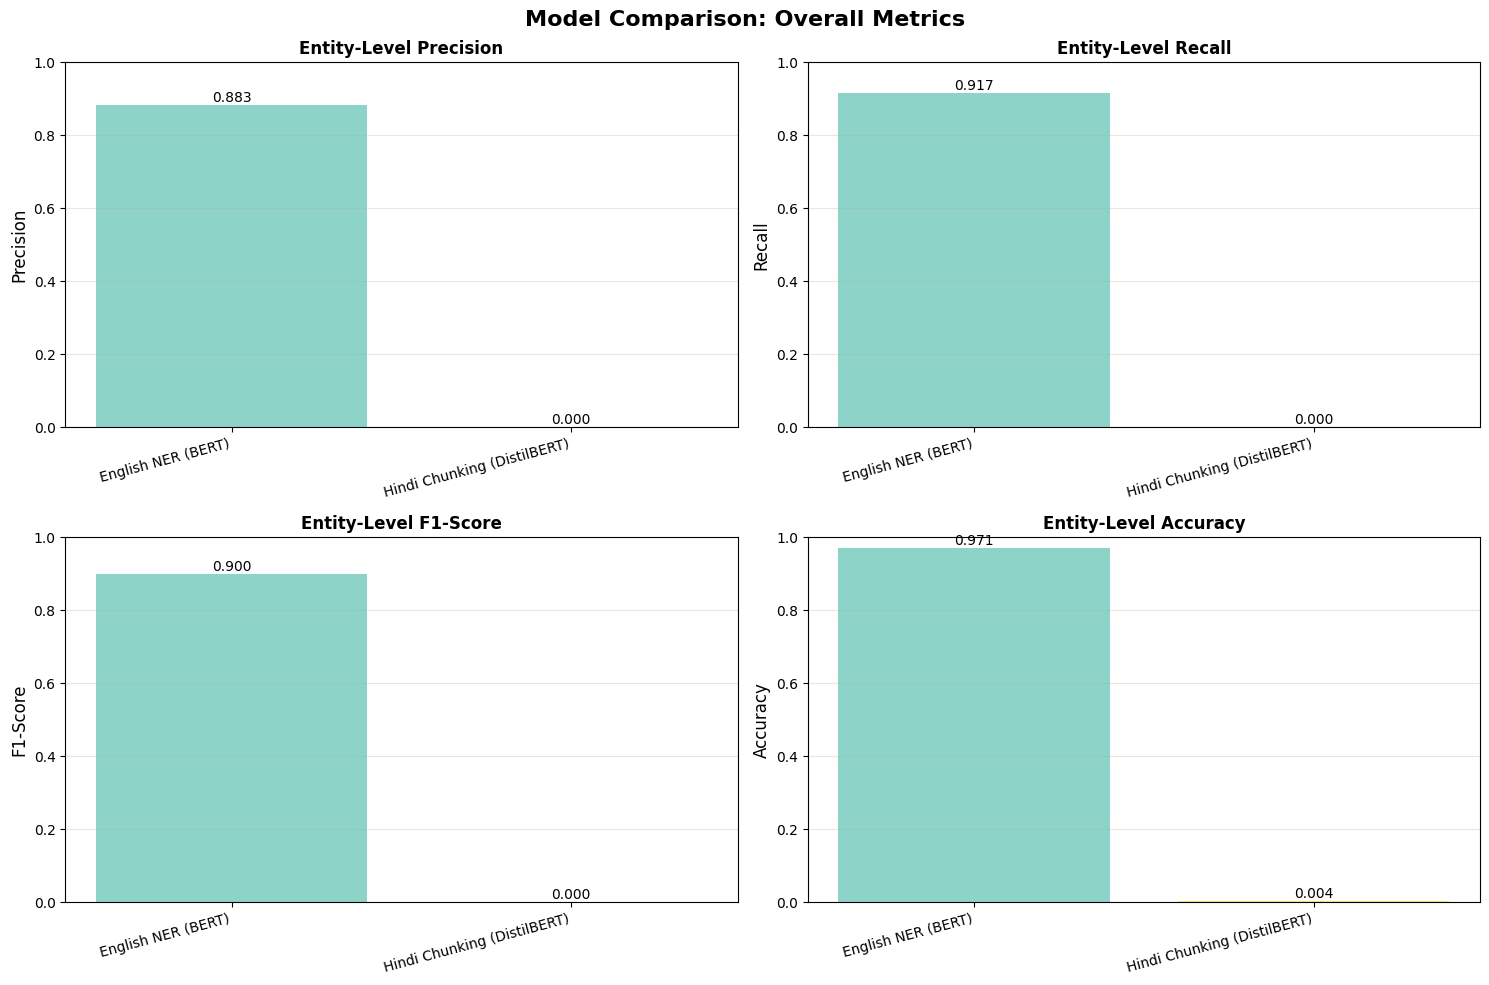

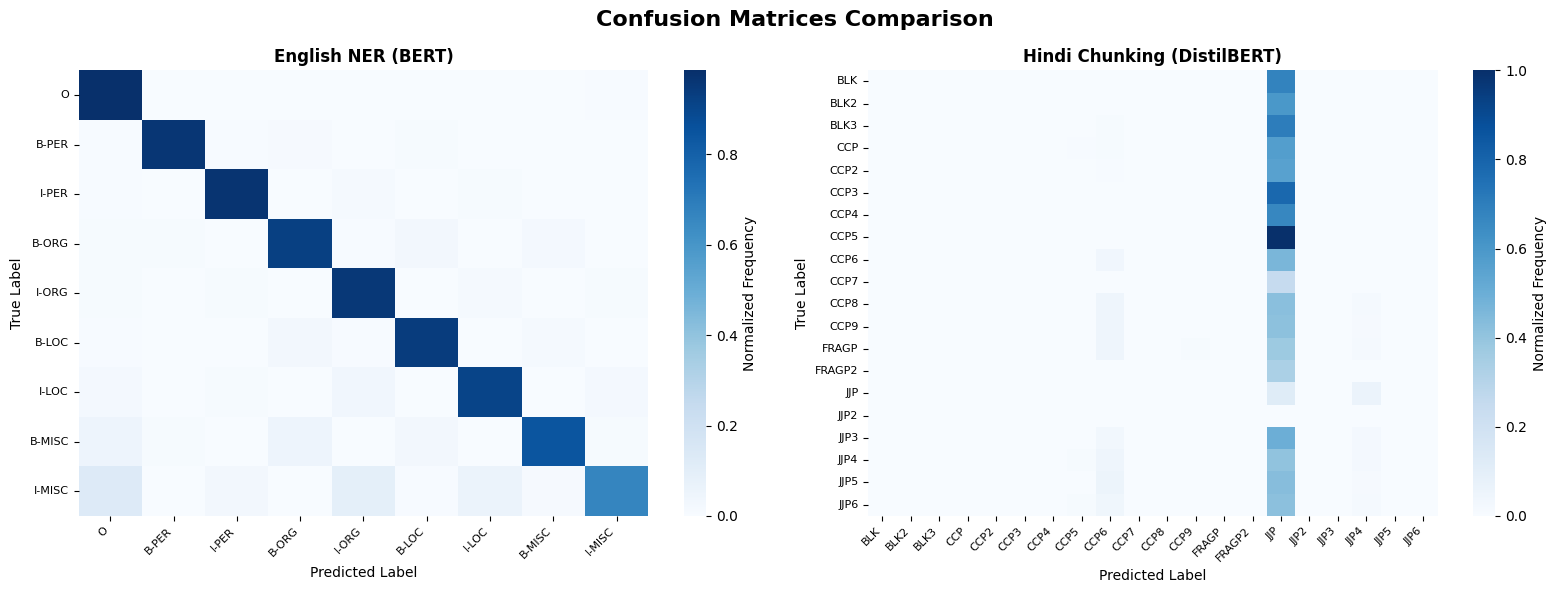

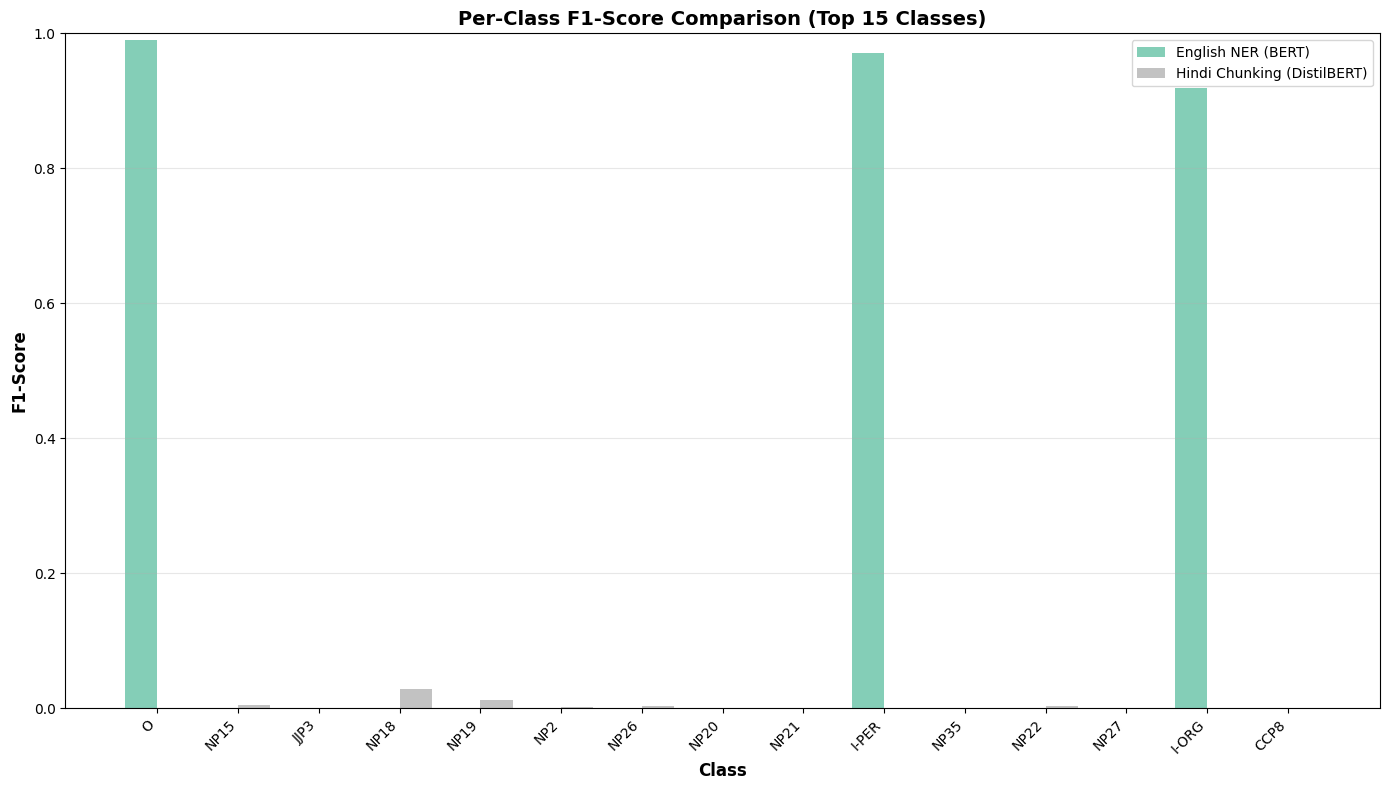

In [57]:
evaluator.create_visualisation(save_dir='./evaluation_plots')

In [58]:
evaluator.save_results('evaluation_results.json')


 Results saved to evaluation_results.json
